In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
sys.path.insert(0,"..")
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import sys
import torch.nn.functional as F

In [3]:
import torchxrayvision as xrv

In [5]:
d_nih = xrv.datasets.NIH_Dataset(imgpath="/lustre04/scratch/cohenjos/NIH/images-224")
xrv.datasets.relabel_dataset(xrv.datasets.default_pathologies, d_nih)

Lung Lesion doesn't exist. Adding nans instead.
Fracture doesn't exist. Adding nans instead.
Lung Opacity doesn't exist. Adding nans instead.
Enlarged Cardiomediastinum doesn't exist. Adding nans instead.


In [6]:
d_pc = xrv.datasets.PC_Dataset(imgpath="/lustre04/scratch/cohenjos/PC/images-224")
xrv.datasets.relabel_dataset(xrv.datasets.default_pathologies, d_pc)

Lung Lesion doesn't exist. Adding nans instead.
Lung Opacity doesn't exist. Adding nans instead.
Enlarged Cardiomediastinum doesn't exist. Adding nans instead.


In [5]:
d_covid19 = xrv.datasets.COVID19_Dataset(imgpath="/raid/COVID19/covid-chestxray-dataset/images",
                                      csvpath="/raid/COVID19/covid-chestxray-dataset/metadata.csv",
                                     views=["PA"])

{'ARDS': 0.0,
 'Bacterial Pneumonia': 0.0,
 'COVID-19': 1.0,
 'Chlamydophila': 0.0,
 'Fungal Pneumonia': 0.0,
 'Influenza': 0.0,
 'Klebsiella': 0.0,
 'Legionella': 0.0,
 'Lipoid': 0.0,
 'MERS': 0.0,
 'Mycoplasma': 0.0,
 'No Finding': 0.0,
 'Pneumocystis': 0.0,
 'Pneumonia': 1.0,
 'SARS': 0.0,
 'Streptococcus': 0.0,
 'Varicella': 0.0,
 'Viral Pneumonia': 1.0}

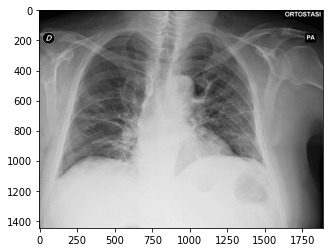

In [6]:
sample = d_covid19[40]
plt.imshow(sample["img"][0], cmap="Greys_r");
dict(zip(d_covid19.pathologies,sample["lab"]))

In [9]:
model = xrv.models.DenseNet(weights="all_cropped_relabelled-nih_v1")
with torch.no_grad():
    out = model(torch.from_numpy(sample["img"]).unsqueeze(0)).cpu()
    
dict(zip(d_covid19.pathologies,zip(out[0].detach().numpy(), sample["lab"])))

EOFError: Ran out of input

In [36]:
model = xrv.models.DenseNet(weights="nih")
with torch.no_grad():
    out = model(torch.from_numpy(sample["img"]).unsqueeze(0)).cpu()
    
dict(zip(d_pc.pathologies,zip(out[0].detach().numpy(), sample["lab"])))

{'Atelectasis': (0.5566849, 0.0),
 'Consolidation': (0.52457345, 1.0),
 'Infiltration': (0.5974177, 1.0),
 'Pneumothorax': (0.5071652, 0.0),
 'Edema': (0.5025493, 0.0),
 'Emphysema': (0.5023997, 0.0),
 'Fibrosis': (0.5037091, 0.0),
 'Effusion': (0.7760436, 1.0),
 'Pneumonia': (0.5019207, 0.0),
 'Pleural_Thickening': (0.6217193, 0.0),
 'Cardiomegaly': (0.52505857, 0.0),
 'Nodule': (0.5426084, 0.0),
 'Mass': (0.6622993, 0.0),
 'Hernia': (0.5013983, 0.0),
 'Lung Lesion': (nan, nan),
 'Fracture': (nan, nan),
 'Lung Opacity': (nan, nan),
 'Enlarged Cardiomediastinum': (nan, nan)}

In [10]:
# small test eval

In [50]:
outs = []
labs = []
with torch.no_grad():
    for i in range(500):
        sample = d_nih[i]
        labs.append(sample["lab"])
        out = model(torch.from_numpy(sample["img"]).unsqueeze(0)).cpu()
        out = torch.sigmoid(out)
        outs.append(out.detach().numpy()[0])

In [51]:
import sklearn, sklearn.metrics
for i in range(14):
    if len(np.unique(np.asarray(labs)[:,i])) > 1:
        auc = sklearn.metrics.roc_auc_score(np.asarray(labs)[:,i], np.asarray(outs)[:,i])
    else:
        auc = "(Only one class observed)"
    print(xrv.datasets.default_pathologies[i], auc)
        

Atelectasis 0.7548369565217391
Consolidation 0.8829324833381629
Infiltration 0.6846330275229358
Pneumothorax 0.8772635814889336
Edema 0.7314629258517035
Emphysema 0.8235731548614984
Fibrosis 0.6838931955211025
Effusion 0.8797409188034188
Pneumonia 0.7891566265060241
Pleural_Thickening 0.5805408583186361
Cardiomegaly 0.9346287393162394
Nodule 0.5917366946778712
Mass 0.8877551020408163
Hernia 0.9984879032258065
